In [1]:
# toc
import time

import matplotlib.pyplot as plt
import pandas as pd

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# tensorflow/keras
# this is the new preferring method of importing according to tensorflow
# See https://github.com/tensorflow/tensorflow/issues/53144
from keras.api.models import Sequential
from keras.api.layers import Dense, Input
from keras import backend as k
import tensorflow as tf

tf.config.set_visible_devices([], 'GPU')
plt.style.use('../maroon_ipynb.mplstyle')

# Problem 1
Included with the homework is a file containing a number of metrics for different car models. The columns are, in order, the fuel economy in MPG, number of cylinders, displacement, horsepower, weight, acceleration, model year, and place of origin (1 is USA, 2 is Europe, and 3 is Japan). The goal of this assignment will be to create a neural network regression model that can predict fuel economy.

You will notice some of the horsepower values are missing. Remove those entries from the database. For the remaining database, construct a neural network that takes the 7 non-MPG values as an input. To begin with, use a single hidden layer of 64 neurons and an 80/20 train/test split and try to minimize the mean squared error for a test set of data (not the data you trained on). Show the evolution of the training and validation error as a function of epoch.

## Solution
Let's get the data loaded.

In [2]:
columns = [
    "mpg",
    "cylinders",
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
    "model_year",
    "origin",
    "car_name"
]

# I removed the rows with no horsepower values
df = pd.read_csv('auto-mpg.data', sep=r'\s+', names=columns)

# Drop the car name
df = df.drop(columns=['car_name'])

# Separate features and target
features = df.drop(columns=['mpg'])
target = df['mpg']

# Get training and testing data
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=12)

# Scale the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

df.head().transpose()

,0,1,2,3,4
mpg,18.0,15.0,18.0,16.0,17.0
cylinders,8.0,8.0,8.0,8.0,8.0
displacement,307.0,350.0,318.0,304.0,302.0
horsepower,130.0,165.0,150.0,150.0,140.0
weight,3504.0,3693.0,3436.0,3433.0,3449.0
acceleration,12.0,11.5,11.0,12.0,10.5
model_year,70.0,70.0,70.0,70.0,70.0
origin,1.0,1.0,1.0,1.0,1.0


Now we can create our model that has 64 neurons in the hidden layer and a single output neuron. The input layer is the number of feature columns we have, which is 7.

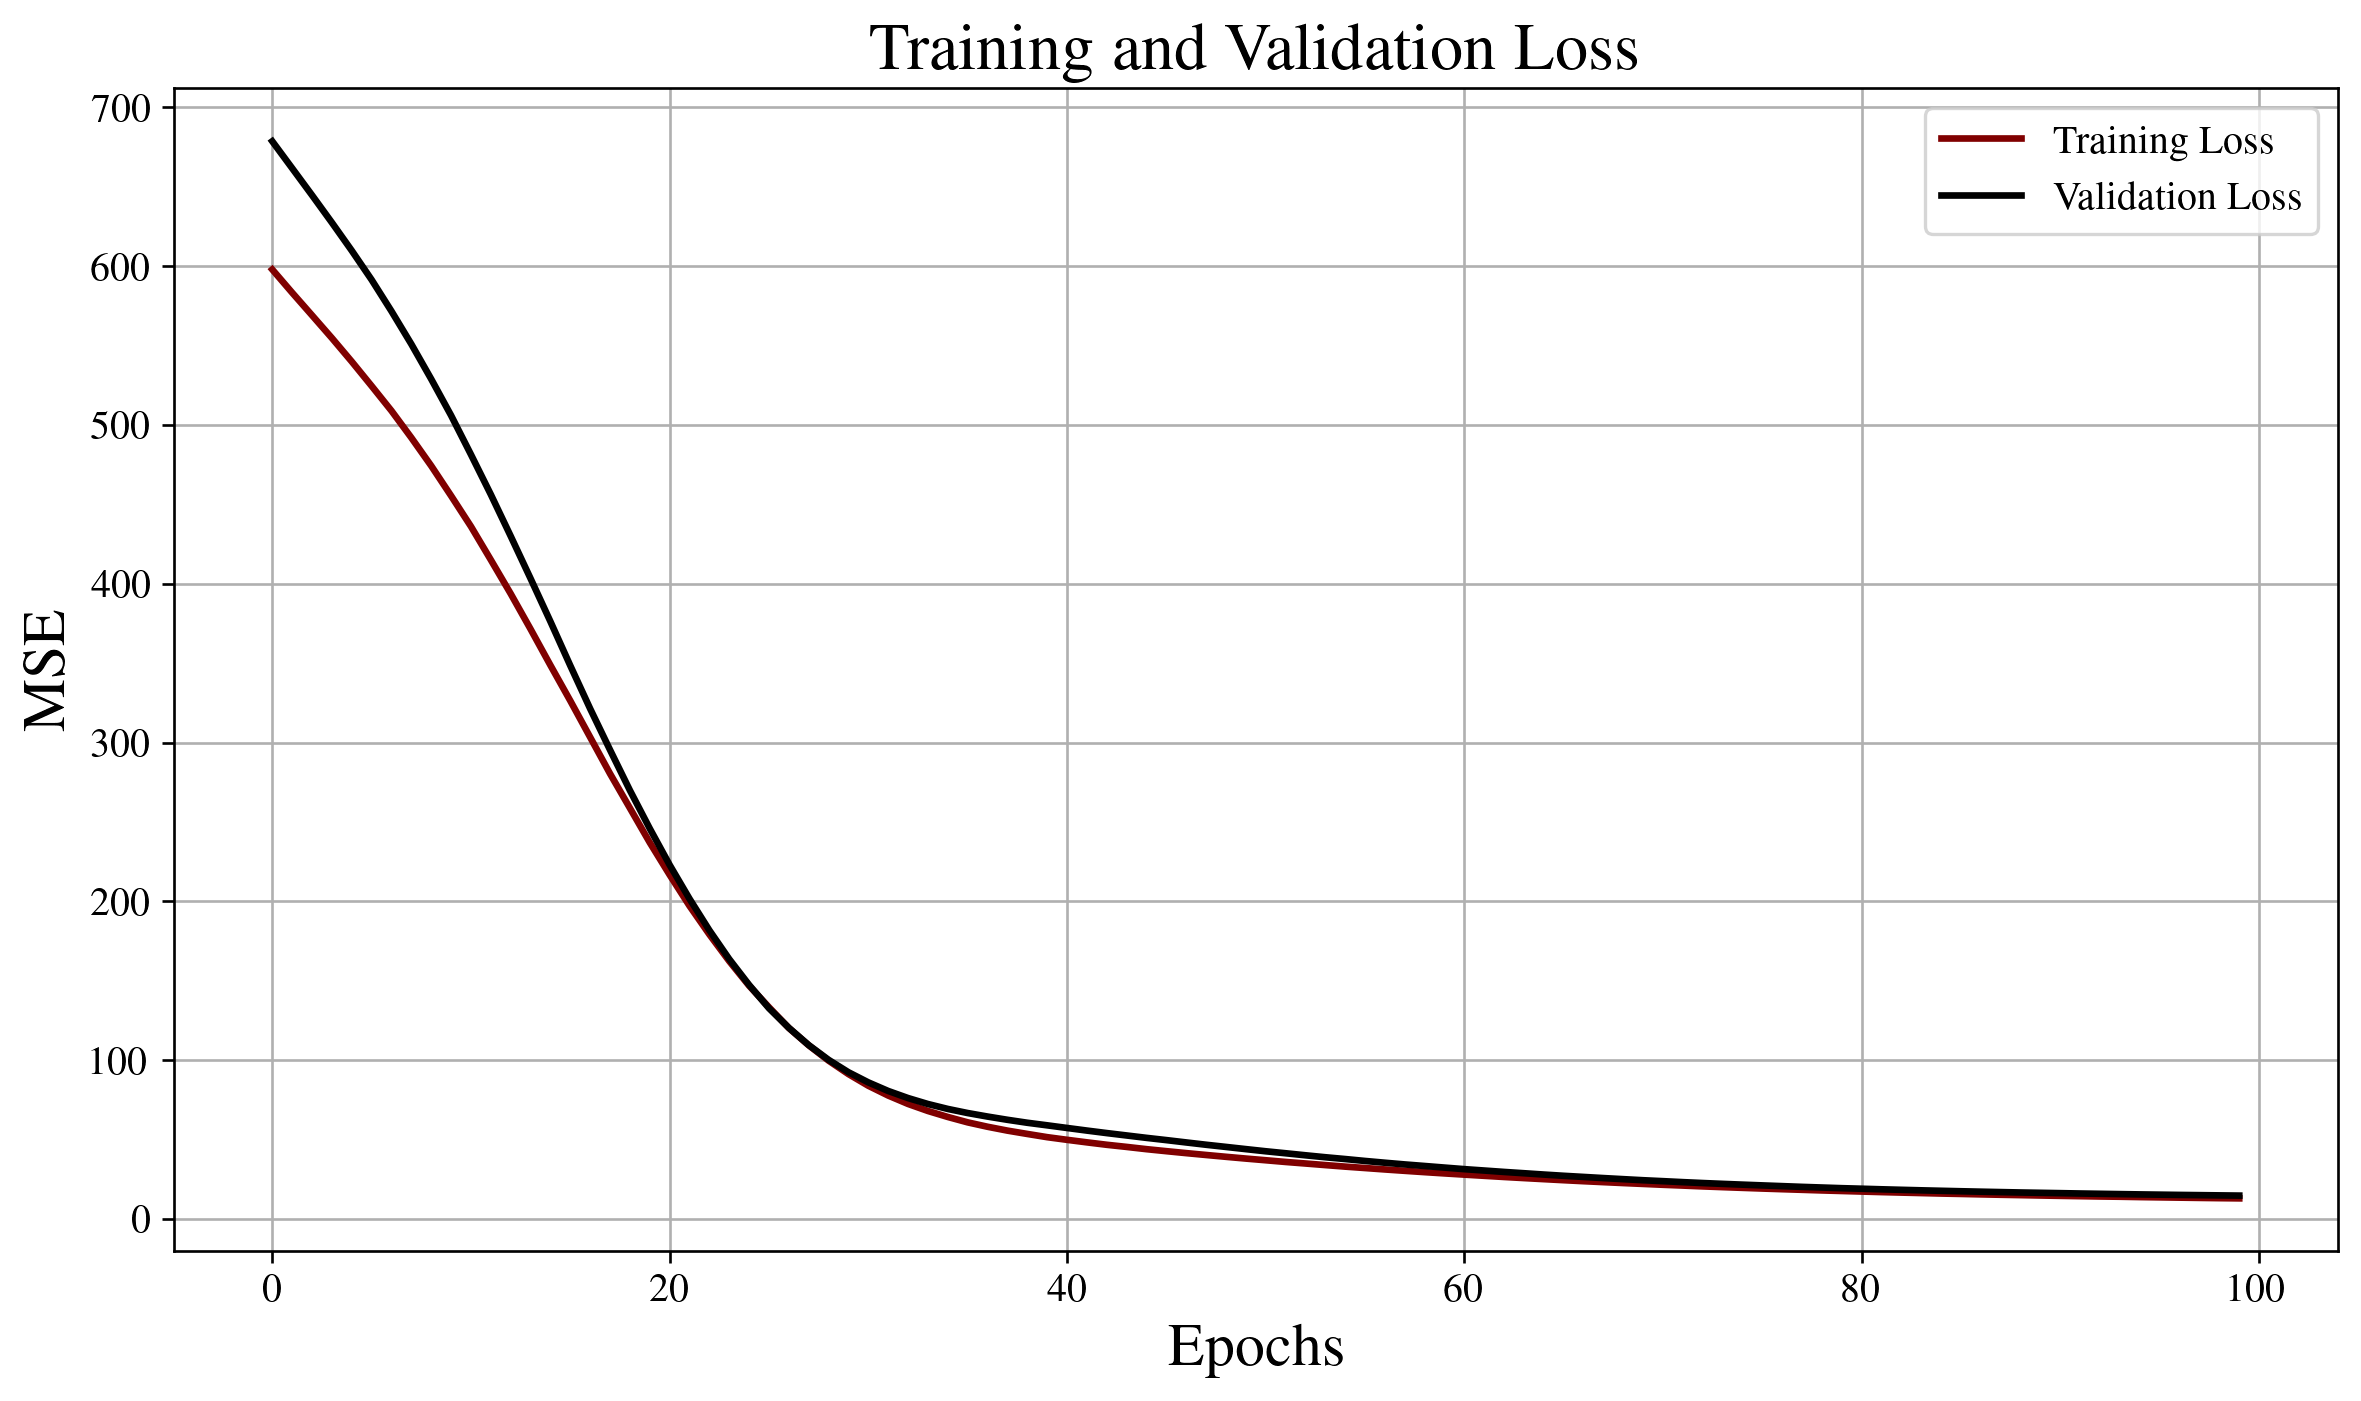

In [3]:
# Make and train the model
k.clear_session()
model = Sequential([
    Input(shape=(x_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), verbose=False)

# Get the training and validation loss
epochs = history.epoch
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot
fig, ax = plt.subplots()
ax.plot(epochs, train_loss, label='Training Loss')
ax.plot(epochs, val_loss, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')
ax.set_title('Training and Validation Loss')
ax.legend()
plt.show()

If you don't normalize the features, then this graph will be very different each time. The training loss will be much higher in the beginning depending on the initial random weights, but normalizing helps to keep the scale consistent.

# Problem 2
Vary the batch size over at least an order of magnitude and see how it affects the training. What batch size converges the fastest? What differences do you observe in the training?

## Solution
We can iterate through a list of batch sizes and train the model for each one. We need to capture the time for this as well and observe the trends. Note: The batch size should not be greater than the number of training samples.

Batch Size: 8, Training Time: 3.27 sec, Final Training Loss: 5.7922
Batch Size: 16, Training Time: 2.65 sec, Final Training Loss: 7.1603
Batch Size: 32, Training Time: 2.39 sec, Final Training Loss: 10.9140
Batch Size: 64, Training Time: 2.22 sec, Final Training Loss: 33.7301
Batch Size: 128, Training Time: 2.15 sec, Final Training Loss: 82.5043
Batch Size: 256, Training Time: 2.12 sec, Final Training Loss: 205.0849


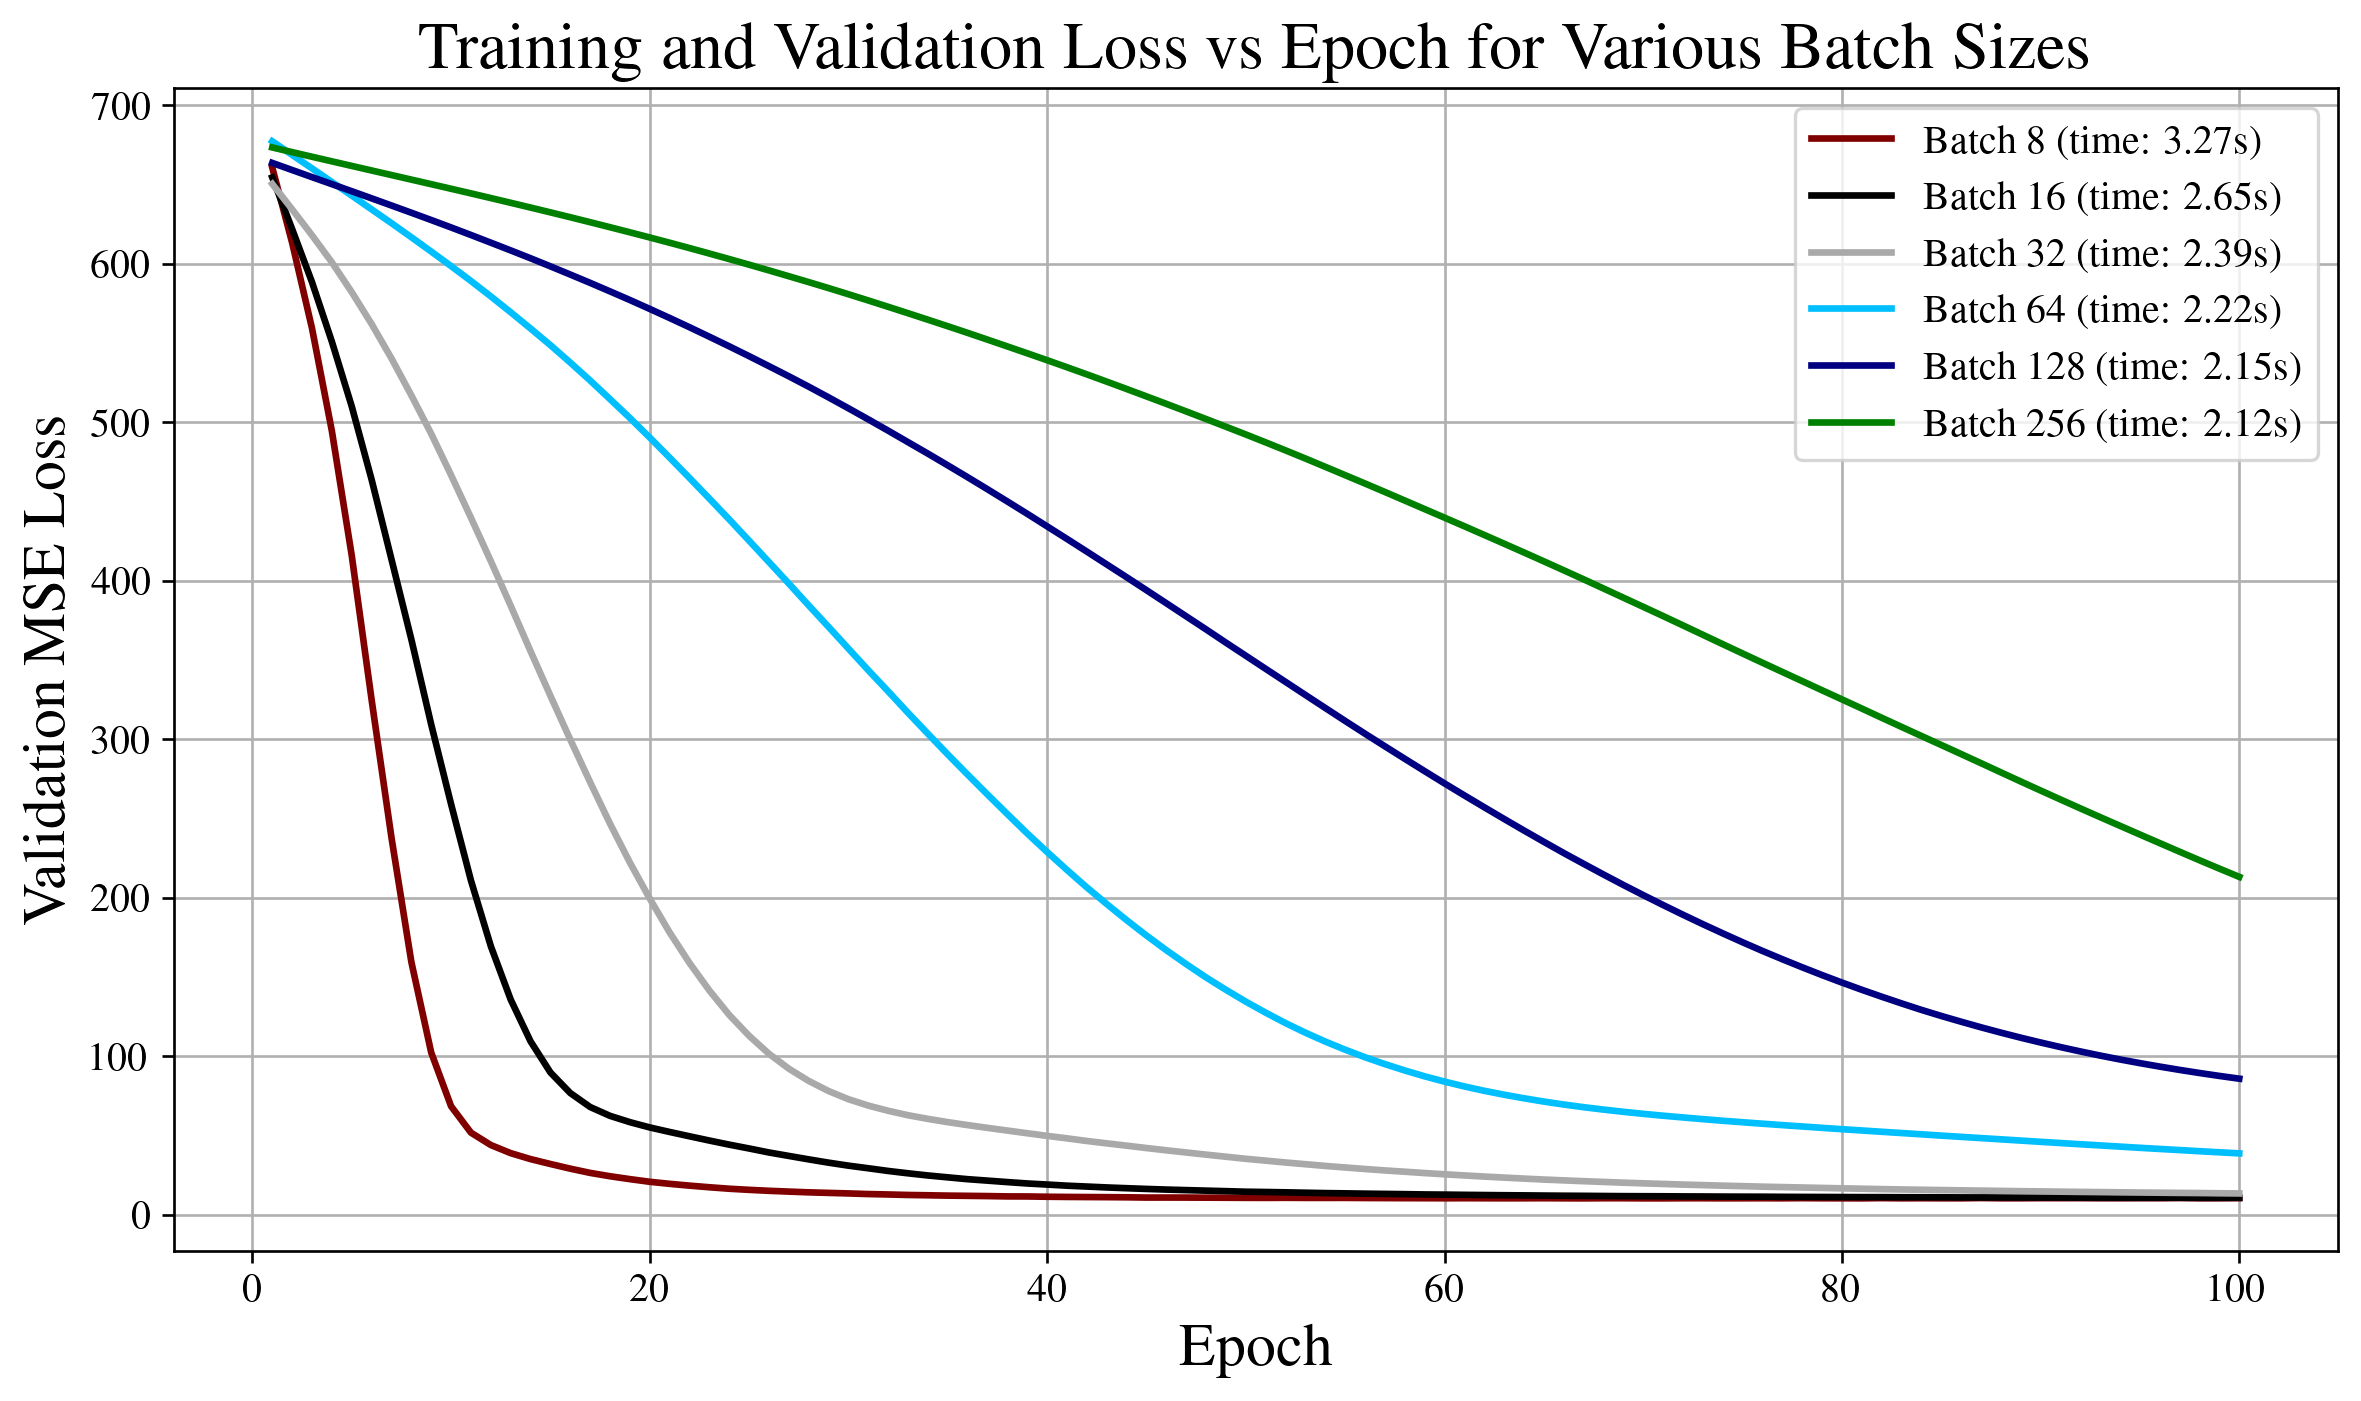

In [4]:
# Define a list of batch sizes (all ≤ 313, which is the training set size)
batch_sizes = [8, 16, 32, 64, 128, 256]

training_times_dict = {}
histories = {}

for bs in batch_sizes:
    k.clear_session()  # Ensure each run starts fresh

    # Build a fresh model for this batch size
    model = Sequential([
        Input(shape=(x_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    # Measure training time using time.perf_counter()
    start_time = time.perf_counter()
    history = model.fit(x_train, y_train, epochs=100,
                        validation_data=(x_test, y_test),
                        batch_size=bs, verbose=False)
    elapsed_time = time.perf_counter() - start_time

    training_times_dict[bs] = elapsed_time
    histories[bs] = history.history

    print(f"Batch Size: {bs}, Training Time: {elapsed_time:.2f} sec, Final Training Loss: {history.history['loss'][-1]:.4f}")

# Plot the training and validation loss vs. epoch curves for all batch sizes on a log scale
fig, ax = plt.subplots()
for bs in batch_sizes:
    val_loss = histories[bs]['val_loss']
    elapsed_time = training_times_dict[bs]
    epochs_range = range(1, len(train_loss) + 1)

    # Plot validation loss with dashed line and x markers
    ax.plot(epochs_range, val_loss, label=f'Batch {bs} (time: {elapsed_time:.2f}s)')

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation MSE Loss')
ax.set_title('Training and Validation Loss vs Epoch for Various Batch Sizes')
ax.legend()
plt.show()

Smaller batch sizes, such as 8 or 16, lead to noisier gradient updates that can help the model converge in fewer epochs and achieve a lower validation loss. Although each epoch may take slightly longer with smaller batches, the overall training can be more efficient since fewer epochs are required for convergence. In contrast, larger batch sizes speed up per-epoch training but often result in a higher validation loss and require more epochs to reach comparable performance.